## Apple Music Replay - Recreated using BigQuery

Apple music has recently launched a 'replay' feature much akin to 'Spotify wrapped', although they only provide a high level summary of a user's listening history. Throughout this notebook, I aim to drill down slightly deeper on what I've been listening to for the last 5 years.

In [1]:
import os
import numpy as np
from google.cloud import bigquery
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

#sns.set()
sns.set_style("white")

Export api_key as a environment variable and set up a bigquery client instance.

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/jcmunday/Desktop/apple_music_replay/apple-music-replay-3ccf5c1d512e.json"     
client = bigquery.Client()

### Overview of Listening Habits
Now let's begin with a high level analysis of my listening habits, through inspecting ```Apple Music Play Activity.csv```. You will need to upload this into a GCP bucket inside your project and then load this as a dataset into BigQuery. I give full details how to do this using the gcloud command line tools in the README.md for this project.

   year  hours_listened
0  2021           310.4
1  2020           918.6
2  2019           987.0
3  2018          1097.1
4  2017           920.2
5  2016           241.9


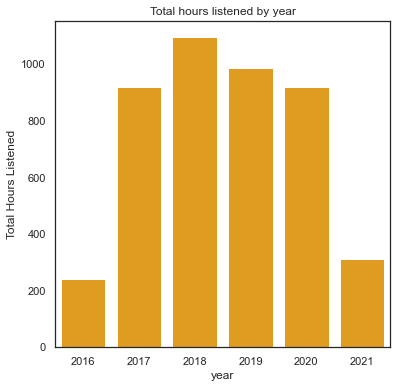

In [3]:
HoursListened = """
    SELECT EXTRACT(YEAR FROM Event_End_Timestamp) year, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY year
    HAVING year IS NOT NULL
    ORDER BY year DESC
    """
df = client.query(HoursListened).to_dataframe()
print(df.head(10))

plt.figure(figsize=(6, 6))
sns.set_context('notebook')
plt.title('Total hours listened by year')
sns.barplot(data=df, x='year', y='hours_listened', ci=None, color='orange')
plt.ylabel('Total Hours Listened')
plt.show()

Mean # of hours listened per day: 2.5.
Max # of hours listened in 1 day: 9.3.


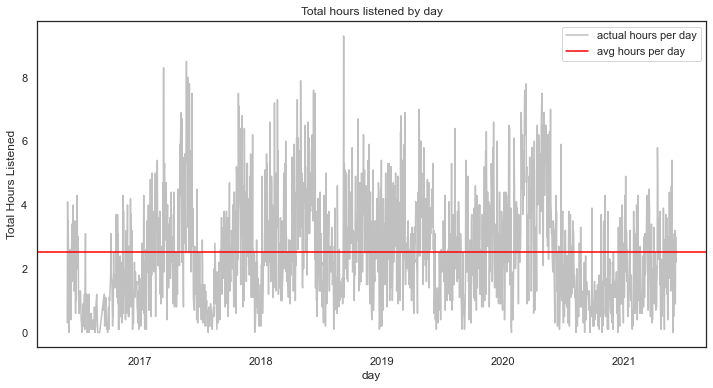

In [4]:
HoursListened_by_day = """
    SELECT EXTRACT(DATE FROM Event_End_Timestamp) day, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY day
    """
df = client.query(HoursListened_by_day).to_dataframe()
avg_hours = df['hours_listened'].mean()
max_hours = df['hours_listened'].max()

print(f'Mean # of hours listened per day: {round(avg_hours,1)}.')
print(f'Max # of hours listened in 1 day: {max_hours}.')

#print(df.head(50))

plt.figure(figsize=(12, 6))
sns.set_context('notebook')

plt.title('Total hours listened by day')
sns.lineplot(data=df, x='day', y='hours_listened', ci=None, color='#C0C0C0', label='actual hours per day')
plt.axhline(avg_hours,color='r', linestyle='-', label='avg hours per day')
plt.ylabel('Total Hours Listened')
plt.legend(loc="upper right")
plt.show()

Looking at the listening history on a day level is too granular to draw any insightful conclusions. Lets instead aggregated by month of the year

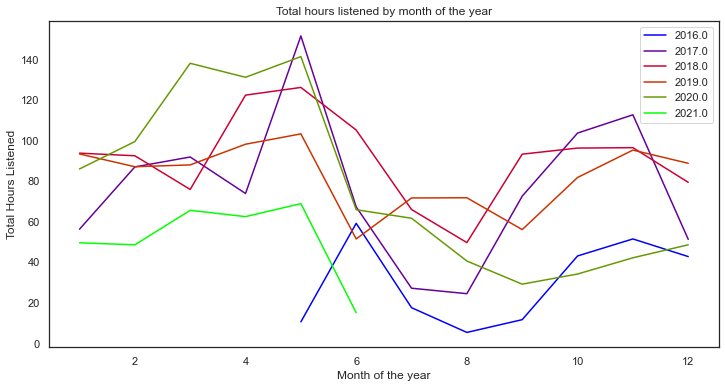

In [5]:
hours_listened_by_month = """
    SELECT EXTRACT(YEAR FROM Event_End_Timestamp) year, EXTRACT(MONTH FROM Event_End_Timestamp) month, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY year, month
    ORDER BY month
    """
df = client.query(hours_listened_by_month).to_dataframe()
avg_hours = df['hours_listened'].mean()
#print(df.head(50))

plt.figure(figsize=(12, 6))
sns.set_context('notebook')
#sns.set_palette("bright")

plt.title('Total hours listened by month of the year')
sns.lineplot(data=df, x='month', y='hours_listened', ci=None, hue='year', palette = 'brg')
plt.xlabel('Month of the year')
plt.ylabel('Total Hours Listened')
plt.legend(loc="upper right")
plt.show()

Interestingly my listening peaks around may/june time, which coincedes with when I would typically have spent most days in the library studying for my uni exams.

### Artist Popularity

In [6]:
uniqueArtistByYear = """
    SELECT EXTRACT(YEAR FROM Event_End_Timestamp) year, COUNT(DISTINCT Artist_Name) uniqueArtists
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY year
    HAVING year IS NOT NULL
    ORDER BY year ASC
    """
df = client.query(uniqueArtistByYear).to_dataframe()
print(df.head(10))

   year  uniqueArtists
0  2016            246
1  2017            612
2  2018            999
3  2019           1204
4  2020           1049
5  2021            512


In [7]:
Top10_AllYears = """
    SELECT Artist_Name, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000.0),1) AS hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history`
    GROUP BY Artist_Name
    ORDER BY hours_listened DESC
    LIMIT 10
    """
df  = client.query(Top10_AllYears).to_dataframe()
print(df.head(15))

      Artist_Name  hours_listened
0      John Mayer           164.7
1  Kendrick Lamar           159.4
2         J. Cole           122.0
3  Anderson .Paak           108.0
4           Logic           102.9
5           Foals            96.3
6      Kanye West            90.0
7     Lupe Fiasco            78.2
8       Tom Misch            61.1
9           JAY-Z            59.5


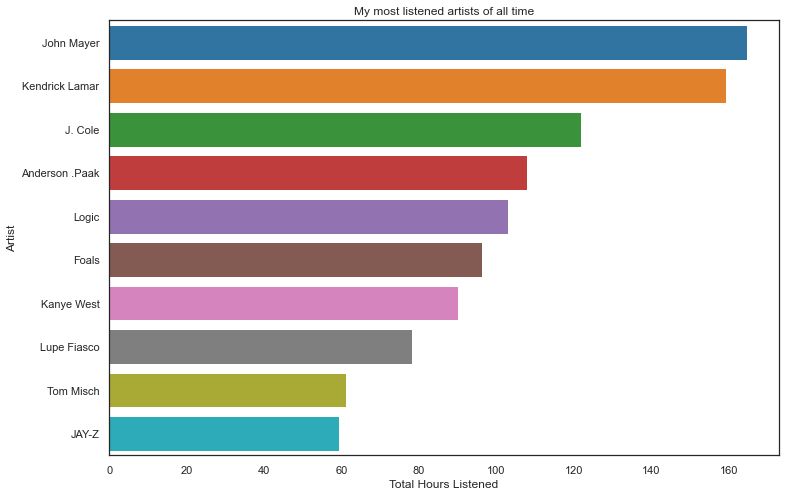

In [8]:
plt.figure(figsize=(12,8))
sns.set_context('notebook')


sns.set_color_codes("pastel")
sns.barplot(x="hours_listened", y="Artist_Name", data=df)
plt.title("My most listened artists of all time")
plt.xlabel("Total Hours Listened")
plt.ylabel("Artist")

plt.show()

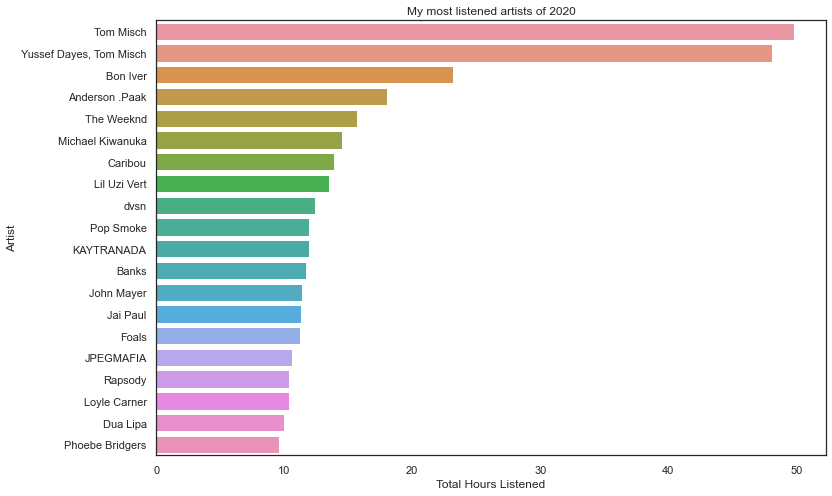

In [9]:
Top10_2020_Only = """
    SELECT Artist_Name, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000.0),1) hours_listened, count(*) play_count, RANK() OVER(ORDER BY SUM(Play_Duration_Milliseconds)/(60*60*1000.0) DESC) AS rank
    FROM `apple-music-replay.apple_music_data.listening_history`
    WHERE EXTRACT(YEAR FROM Event_End_Timestamp) = 2020 
    GROUP BY Artist_Name
    ORDER BY hours_listened DESC
    LIMIT 20
    """
df  = client.query(Top10_2020_Only).to_dataframe()

plt.figure(figsize=(12,8))
sns.set_context('notebook')
sns.set_color_codes("pastel")
sns.barplot(x="hours_listened", y="Artist_Name", data=df)
plt.title("My most listened artists of 2020")
plt.xlabel("Total Hours Listened")
plt.ylabel("Artist")

plt.show()

In [10]:
rank_by_year= """
    SELECT RANK() OVER(PARTITION BY  year  ORDER BY  hours_listened DESC ) rank, year, Artist_name, hours_listened
    FROM
        (SELECT  Artist_Name, EXTRACT(YEAR FROM Event_End_Timestamp) year, SUM(Play_Duration_Milliseconds)/(60*60*1000.0) AS hours_listened
        FROM `apple-music-replay.apple_music_data.listening_history`
        GROUP BY Artist_Name, year
        HAVING year IS NOT NULL
        ORDER BY hours_listened DESC)
    ORDER BY rank ASC, year
    """
df=client.query(rank_by_year).to_dataframe()
print(df.head(15))

    rank  year              Artist_name  hours_listened
0      1  2016         Ludovico Einaudi       22.878768
1      1  2017               John Mayer       90.287533
2      1  2018               Kanye West       60.564022
3      1  2019           Anderson .Paak       47.536626
4      1  2020                Tom Misch       49.762552
5      1  2021                Radiohead       14.969546
6      2  2016     The Notorious B.I.G.       18.504922
7      2  2017           Kendrick Lamar       62.322433
8      2  2018           Kendrick Lamar       56.763233
9      2  2019                   Skepta       28.845409
10     2  2020  Yussef Dayes, Tom Misch       48.102186
11     2  2021             Jordan Rakei       13.781110
12     3  2016                  J. Cole       18.044638
13     3  2017                    Logic       58.622628
14     3  2018                  J. Cole       42.383546


In [11]:
pivot_table = df.pivot_table(index=['rank'],
                            columns=['year'],
                            values=['Artist_name'],
                            aggfunc=lambda x: ' '.join(str(ch) for ch in x))
pivot_table.to_csv('output_data/ArtistRankingByYear.csv', encoding='utf-8',index=False)
print(pivot_table.head(25))

                                  Artist_name  \
year                                     2016   
rank                                            
1                            Ludovico Einaudi   
2                        The Notorious B.I.G.   
3                                     J. Cole   
4                              Kendrick Lamar   
5                               Bryson Tiller   
6                           Chance the Rapper   
7                                       Foals   
8                               Ariana Grande   
9                                    Ice Cube   
10                                   A$AP Mob   
11                           Childish Gambino   
12                                Joey Bada$$   
13                                   2 Chainz   
14                                      JAY-Z   
15                           Shelley FKA DRAM   
16                                 Kanye West   
17                        Nothing But Thieves   
18                  

In [12]:
journey_to_most_listened = """
SELECT Artist_Name, 
    EXTRACT(DATE FROM Event_End_Timestamp) date_of_play, 
    (1/(60*60*1000))*SUM(Play_Duration_Milliseconds) OVER (PARTITION BY Artist_Name ORDER BY Event_End_Timestamp) Running_Total_Play_Time
FROM `apple-music-replay.apple_music_data.listening_history`
WHERE Artist_Name IN ('John Mayer', 'Tom Misch', 'Bon Iver','Kendrick Lamar', 'J. Cole','Anderson .Paak','Logic', 'Foals', 'Kanye West', 'Lupe Fiasco', 'JAY-Z') AND
    EXTRACT(DATE FROM Event_End_Timestamp) IS NOT NULL
ORDER BY Event_End_Timestamp ASC
"""

df=client.query(journey_to_most_listened).to_dataframe()
print(df.tail(5))

          Artist_Name date_of_play  Running_Total_Play_Time
28503        Bon Iver   2021-06-07                27.388852
28504  Kendrick Lamar   2021-06-07               159.358337
28505           Logic   2021-06-07               102.880838
28506      John Mayer   2021-06-07               164.655763
28507      John Mayer   2021-06-07               164.664517


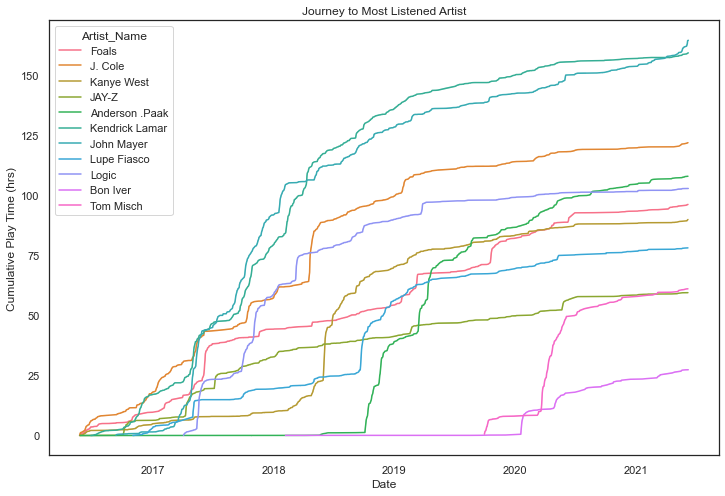

In [13]:
plt.figure(figsize=(12,8))

sns.set_context('notebook')
sns.set_color_codes("pastel")

sns.lineplot(x='date_of_play', y='Running_Total_Play_Time', hue='Artist_Name', data=df)

plt.title('Journey to Most Listened Artist')
plt.xlabel('Date')
plt.ylabel('Cumulative Play Time (hrs)')
plt.show()

Interestingly, we see that artists like John Mayer have been consistently in my rotation with his gradient of cumulative play time still increasing. However artists like Kendrick and Cole have sharply plateaued over the last two years as I have increased the breadth of genres and artists I listen to. Let's try to confirm this by repeating the prior for genre instead of artist.

In [14]:
journey_to_most_listened_genre = """
SELECT Genre,
    EXTRACT(DATE FROM Event_End_Timestamp) date_of_play, 
    (1/(60*60*1000))*SUM(Play_Duration_Milliseconds) OVER (PARTITION BY Genre ORDER BY Event_End_Timestamp) Running_Total_Play_Time
FROM `apple-music-replay.apple_music_data.listening_history`
WHERE EXTRACT(DATE FROM Event_End_Timestamp) IS NOT NULL AND
genre IN (
        SELECT Genre
        FROM `apple-music-replay.apple_music_data.listening_history`
        GROUP BY Genre
        ORDER BY 1/(60*60*1000)*SUM(Play_Duration_Milliseconds) DESC
        LIMIT 10
)
ORDER BY Event_End_Timestamp ASC
"""

df=client.query(journey_to_most_listened_genre).to_dataframe()
print(df.tail(5))

              Genre date_of_play  Running_Total_Play_Time
121533  Hip Hop/Rap   2021-06-07              2102.895439
121534  Hip Hop/Rap   2021-06-07              2102.953805
121535  Hip Hop/Rap   2021-06-07              2103.012181
121536          Pop   2021-06-07               254.056984
121537          Pop   2021-06-07               254.065737


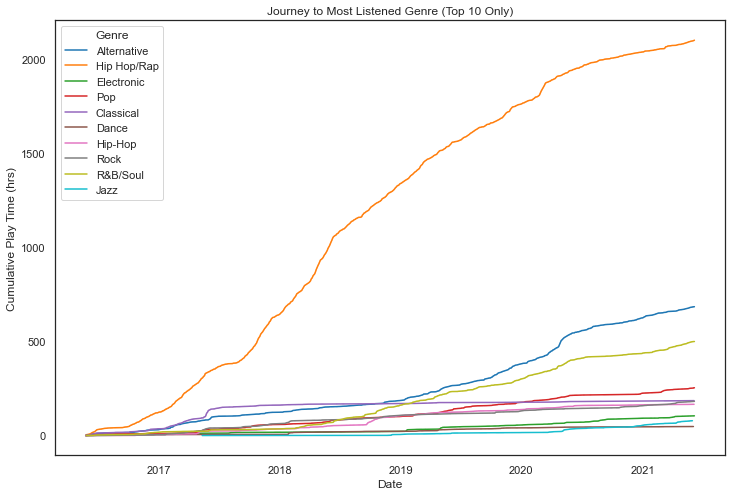

In [15]:
plt.figure(figsize=(12,8))

sns.set_context('notebook')
sns.set_color_codes("bright")
sns.lineplot(x='date_of_play', y='Running_Total_Play_Time', hue='Genre', data=df)
plt.title('Journey to Most Listened Genre (Top 10 Only)')
plt.xlabel('Date')
plt.ylabel('Cumulative Play Time (hrs)')
plt.show()

Hip hop is still clearly my most listened to genre even despite the plateau of my listening habits for top names in hip-hop. I know from my own personal habit's that its dominance is due to me listening to a diverse range of underground and 90s hip hop that when aggregrated has a large contribution to my listening habits.

### Album Popularity
Now finally lets explore my most listening to albums, this will require joining in another dataset as the current dataset being used only has the song titles. ```Apple Music Library Tracks.json``` is also contained in the apple data and privacy request - it containts a summary of all the songs in my apple music library, which is exactly what we need. Through using a simple inner join we can get a column for album title into our listening history dataset and then repeat the prior analysis on artist popularity for album popularity.

Let's begin by generating some high level stats about this dataset.

In [16]:
# `apple-music-replay.apple_music_data.MusicLibrary`

In [17]:
num_albums="""
    SELECT COUNT(DISTINCT album) AS Number_of_Albums_in_Library
    FROM `apple-music-replay.apple_music_data.MusicLibrary`
    """
df = client.query(num_albums).to_dataframe()
print(df)

   Number_of_Albums_in_Library
0                         2186


In [18]:
num_songs="""
    SELECT COUNT(DISTINCT title) AS Number_of_Songs_in_Library
    FROM `apple-music-replay.apple_music_data.MusicLibrary`
    """
df = client.query(num_songs).to_dataframe()
print(df)

   Number_of_Songs_in_Library
0                       13363


Let us do a test join to confirm on a subset of the dataset by listing all of the songs in 'What Kind of Music':

In [19]:
testjoin="""
    SELECT ml.artist, ml.album, lh.Content_Name, COUNT(lh.Content_Name) play_count, SUM(Play_Duration_Milliseconds)/(60*60*1000) play_time_hours
    FROM `apple-music-replay.apple_music_data.listening_history` lh
    LEFT JOIN `apple-music-replay.apple_music_data.MusicLibrary` ml
        ON lh.Content_Name = ml.title
    WHERE ml.album = "What Kinda Music"
    GROUP BY lh.Content_Name, ml.album, ml.artist
"""
df = client.query(testjoin).to_dataframe()
print(df.head(15))

                      artist             album  \
0   Tom Misch & Yussef Dayes  What Kinda Music   
1   Tom Misch & Yussef Dayes  What Kinda Music   
2   Tom Misch & Yussef Dayes  What Kinda Music   
3   Tom Misch & Yussef Dayes  What Kinda Music   
4   Tom Misch & Yussef Dayes  What Kinda Music   
5   Tom Misch & Yussef Dayes  What Kinda Music   
6   Tom Misch & Yussef Dayes  What Kinda Music   
7   Tom Misch & Yussef Dayes  What Kinda Music   
8   Tom Misch & Yussef Dayes  What Kinda Music   
9   Tom Misch & Yussef Dayes  What Kinda Music   
10  Tom Misch & Yussef Dayes  What Kinda Music   
11  Tom Misch & Yussef Dayes  What Kinda Music   

                                    Content_Name  play_count  play_time_hours  
0                                     Tidal Wave         130         7.411157  
1                                       Last 100         124         6.578579  
2                               I Did It For You         132         6.899036  
3               Nightrider (f

In [20]:
WKM="""
    SELECT ml.artist, ml.album, COUNT(lh.Content_Name) song_play_count, SUM(Play_Duration_Milliseconds)/(60*60*1000) play_time_hours
    FROM `apple-music-replay.apple_music_data.listening_history` lh
    LEFT JOIN `apple-music-replay.apple_music_data.MusicLibrary` ml
        ON lh.Content_Name = ml.title
    WHERE ml.album = "What Kinda Music"
    GROUP BY ml.album, ml.artist
"""
df = client.query(WKM).to_dataframe()
print(df.head(12))

                     artist             album  song_play_count  \
0  Tom Misch & Yussef Dayes  What Kinda Music             2128   

   play_time_hours  
0        97.150875  


Surprisingly this figure is correct, when checked against Apple's official replay statistics. Now let's run the same query but for all albums to see how they compare to each other.

In [21]:
all_albums="""
    SELECT ml.artist, ml.album, COUNT(lh.Content_Name) song_play_count, ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),1) hours_listened
    FROM `apple-music-replay.apple_music_data.listening_history` lh
    LEFT JOIN `apple-music-replay.apple_music_data.MusicLibrary` ml
        ON lh.Content_Name = ml.title
    GROUP BY ml.album, ml.artist
    HAVING  ml.artist IS NOT NULL
    ORDER BY hours_listened DESC
"""
# Technically I should have joined on the unique Apple ID Number for each song, 
# although I prematurely dropped this column from the MusicLibrary table before I imported it into GCP.

# One other oddity can be seen in DAMN. and DAMN. COLLECTORS EDITIION. - these are the exact same albums one with the 
# tracks in reverse order hence why they have the exact same play times
df = client.query(all_albums).to_dataframe()
print(df.head(25))

                      artist                                    album  \
0   Tom Misch & Yussef Dayes                         What Kinda Music   
1                      Foals                           What Went Down   
2                 John Mayer                                Continuum   
3                   Bon Iver                                      i,i   
4             Anderson .Paak                                  Ventura   
5             Kendrick Lamar                                    DAMN.   
6             Kendrick Lamar                DAMN. COLLECTORS EDITION.   
7             Kendrick Lamar          good kid, m.A.A.d city (Deluxe)   
8                 The Weeknd                              After Hours   
9                Jorja Smith                             Lost & Found   
10                     Logic          Under Pressure (Deluxe Version)   
11            Kendrick Lamar                      To Pimp A Butterfly   
12               Lupe Fiasco                       

In [22]:
rank_by_year= """
    SELECT RANK() OVER(PARTITION BY  year  ORDER BY  hours_listened DESC ) rank, year, album_title, hours_listened
    FROM

        (
        SELECT  ml.album album_title, 
            EXTRACT(YEAR FROM Event_End_Timestamp) year,
            ROUND(SUM(Play_Duration_Milliseconds)/(60*60*1000),2) hours_listened
        FROM `apple-music-replay.apple_music_data.listening_history` lh
        LEFT JOIN `apple-music-replay.apple_music_data.MusicLibrary` ml
            ON lh.Content_Name = ml.title
        GROUP BY ml.album, year
        HAVING  ml.album IS NOT NULL AND year IS NOT NULL
    ORDER BY hours_listened DESC
    )
    ORDER BY rank ASC, year
    """
df=client.query(rank_by_year).to_dataframe()
# remove duplicate copy of damn
df = df[df['album_title']!= 'DAMN. COLLECTORS EDITION.']
print(df.head(30))

    rank  year                                  album_title  hours_listened
0      1  2016                              In a Time Lapse           15.49
1      1  2017                                        DAMN.           29.37
3      1  2018                           Bobby Tarantino II           25.44
4      1  2019                                      Ventura           42.29
5      1  2020                             What Kinda Music           92.22
6      1  2021                                    The Bends           13.02
7      2  2016                               What Went Down           14.97
8      2  2018                                 Lost & Found           24.25
9      2  2019                           Ignorance Is Bliss           24.87
10     2  2020                                          i,i           42.41
11     2  2021                             Nuttin' but Love           12.99
12     3  2016                                Coloring Book           12.23
13     3  20

In [23]:
pivot_table = df.pivot_table(index=['rank'],
                            columns=['year'],
                            values=['album_title'],
                            aggfunc=lambda x: ' '.join(str(ch) for ch in x))
pivot_table.to_csv('output_data/AlbumRankingByYear.csv', encoding='utf-8',index=False)
print(pivot_table.head(25))

                                            album_title  \
year                                               2016   
rank                                                      
1                                       In a Time Lapse   
2                                        What Went Down   
3                                         Coloring Book   
4                       good kid, m.A.A.d city (Deluxe)   
5                                       T R A P S O U L   
6                           Islands - Essential Einaudi   
7                          Born Sinner (Deluxe Version)   
8                                    "Awaken, My Love!"   
9                              Dangerous Woman (Deluxe)   
10                          Ready to Die - The Remaster   
11                                          Born Sinner   
12                                    Elements (Deluxe)   
13                            Magna Carta... Holy Grail   
14              good kid, m.A.A.d city (Deluxe Version) 